wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 5c7qyf6g
Sweep URL: https://wandb.ai/cs22m010/DL_Assign_2/sweeps/5c7qyf6g


wandb: Agent Starting Run: zp20smlx with config:
wandb: 	activation_fn: GELU
wandb: 	batch_norm: False
wandb: 	data_augmentation: yes
wandb: 	dropout: 0.3
wandb: 	filter_org: same
wandb: 	filter_size: 5
wandb: 	filter_size_org: same
wandb: 	num_filters: 32
wandb: 	num_neuron_fc: 20
wandb: Currently logged in as: cs22m010. Use `wandb login --relogin` to force relogin


epoch 0
Training Loss: 2.303539 	 Training Accuracy: 9.700000
Validation Loss: 2.305151 	 test Accuracy: 10.000000
epoch 1
Training Loss: 2.298255 	 Training Accuracy: 12.100000
Validation Loss: 2.304596 	 test Accuracy: 11.300000
epoch 2
Training Loss: 2.301830 	 Training Accuracy: 9.700000
Validation Loss: 2.304410 	 test Accuracy: 10.000000
epoch 3
Training Loss: 2.297770 	 Training Accuracy: 10.000000
Validation Loss: 2.304947 	 test Accuracy: 10.300000
epoch 4
Training Loss: 2.297096 	 Training Accuracy: 12.400000
Validation Loss: 2.304966 	 test Accuracy: 10.300000
epoch 5
Training Loss: 2.294788 	 Training Accuracy: 12.700000
Validation Loss: 2.305468 	 test Accuracy: 10.250000
epoch 6
Training Loss: 2.298155 	 Training Accuracy: 9.900000
Validation Loss: 2.304002 	 test Accuracy: 10.250000
epoch 7
Training Loss: 2.295637 	 Training Accuracy: 11.600000
Validation Loss: 2.304031 	 test Accuracy: 10.300000
epoch 8
Training Loss: 2.292154 	 Training Accuracy: 12.400000
Validation L

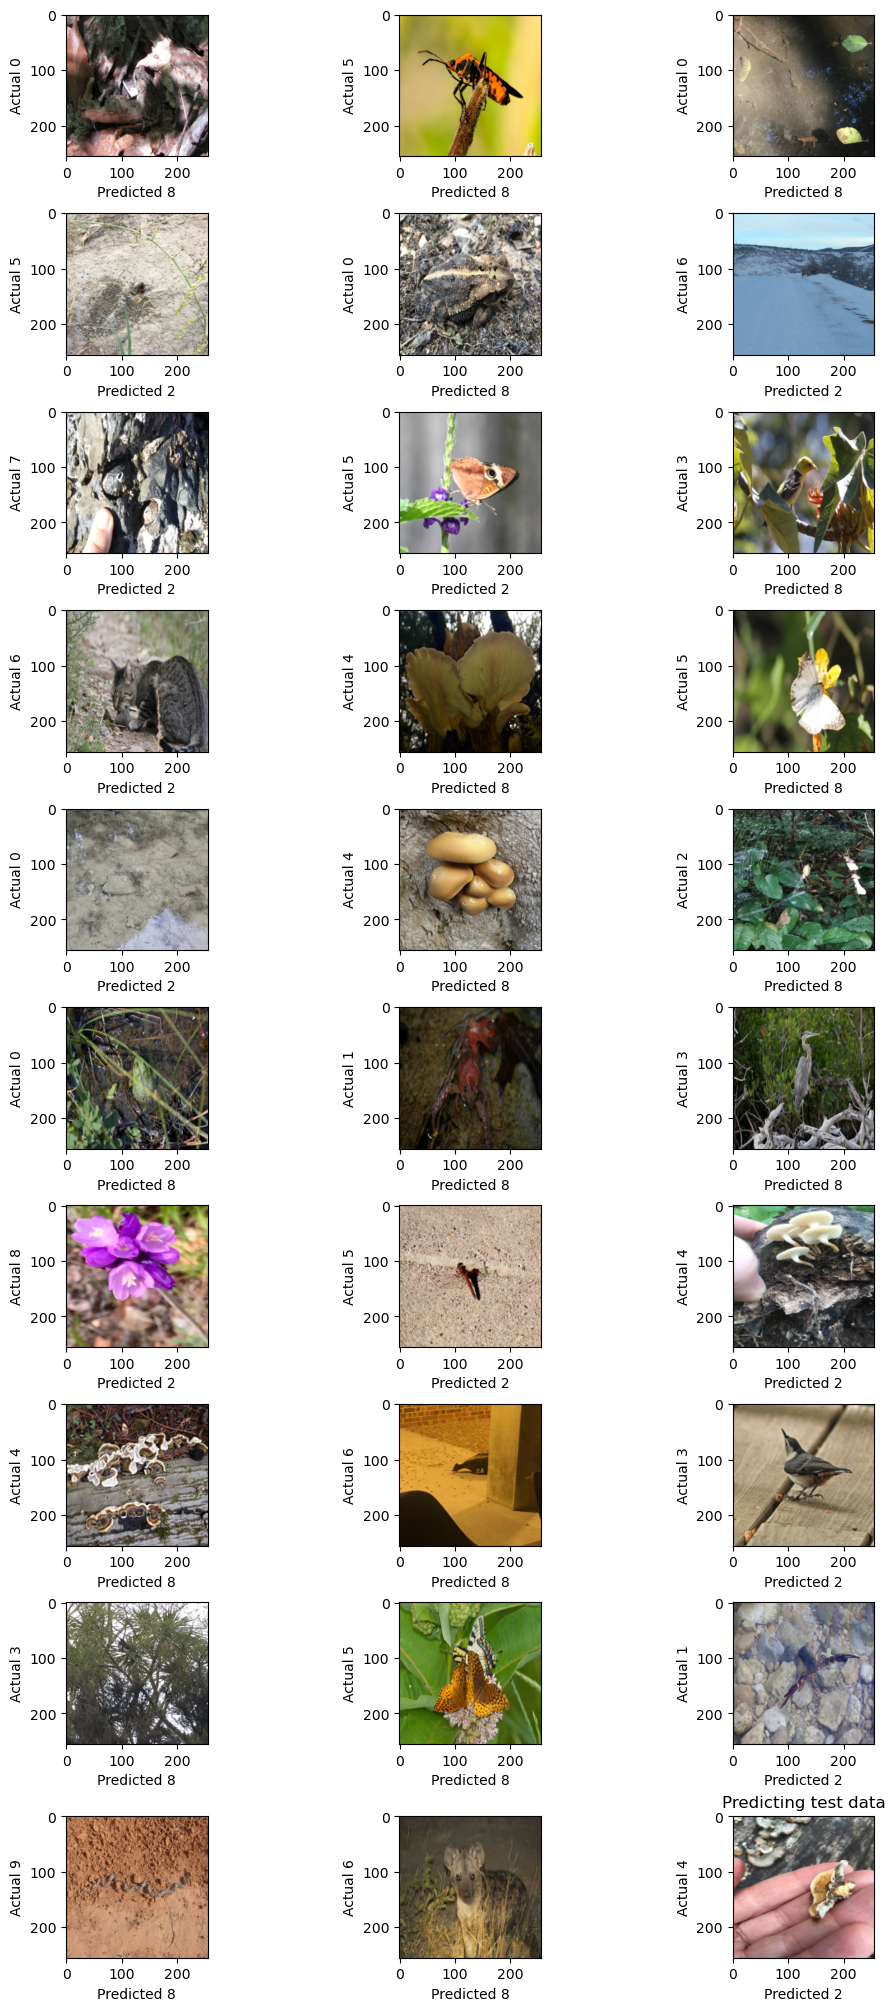

epoch 9
Training Loss: 2.292090 	 Training Accuracy: 13.800000
Validation Loss: 2.301299 	 test Accuracy: 13.150000


test accuracy,▁▄▁▂▂▂▂▂▂█
test loss,▇▇▆▇▇█▆▆▃▁
train accuracy,▁▅▁▂▆▆▁▄▆█
train loss,█▅▇▄▄▃▅▃▁▁
test accuracy,13.15
test loss,2.3013
train accuracy,13.8
train loss,2.29209


In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
#import tensorflow as tf
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch
import wandb
wandb.login(key='e595ff5b95c353a42c4bd1f35b70856d4309ef00')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = '/kaggle/input/inaturalist12k/Data/inaturalist_12K'
#-------------------------------------------------------------------------------------------------------
# def get_transforms(data_augmentation):
#     if data_augmentation=="yes":
#         transform = transforms.Compose([
#             transforms.RandomHorizontalFlip(p=0.5),
#             transforms.RandomVerticalFlip(p=0.5),
#             transforms.RandomRotation(degrees=30),
#             transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
#             transforms.Resize((256,256)),
#             transforms.ToTensor()
#         ])
#     else:
#         transform = transforms.Compose([
#             transforms.Resize((256,256)),
#             transforms.ToTensor()
#         ])
#     return transform

# transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
# train_dataset=torchvision.datasets.ImageFolder(root=data_dir+'/train',transform=get_transforms("yes"))
# test_dataset=torchvision.datasets.ImageFolder(root=data_dir+'/val',transform=transform)

# val_size = int(len(train_dataset) * 0.2)
# train_size = len(train_dataset) - val_size

# train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
# val_loader=DataLoader(val_dataset,batch_size=16,shuffle=False)
# test_loader=DataLoader(test_dataset,batch_size=16,shuffle=False)
#--------------------------------------------------------------------------------------------------------
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
class Mish(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))
# Define the CNN model architecture
class CNN(nn.Module):
    def __init__(self, num_filters, filter_size, activation_fn, filter_org, batch_norm, dropout,num_neuron_fc,filter_size_org):
        super(CNN, self).__init__()
        if(activation_fn=="ReLU"):
            activation_fn=nn.ReLU
        if(activation_fn=="GELU"):
            activation_fn=nn.GELU
        if(activation_fn=="SiLU"):
            activation_fn=nn.SiLU
        if(activation_fn=="Mish"):
            activation_fn=Mish
        if(filter_org=="double"):
            filter_org=[1,2,2,2,2]
        if(filter_org=="same"):
            filter_org=[1,1,1,1,1]
        if(filter_org=="half"):
            filter_org=[1,0.5,0.5,0.5,0.5]
        if(filter_size_org=='same'):
            filter_size_org=[1,1,1,1,1]
        if(filter_size_org=="double"):
            filter_size_org=[1,2,2,2,2]
        if(filter_size_org=="half"):
            filter_size_org=[1,0.5,0.5,0.5,0.5]
        layers = []
        in_channels = 3
        w=256
        for i, f in enumerate(filter_org):
            out_channels = int(num_filters * f)
            filter_size1 = int(filter_size*filter_size_org[i])
            #calculate feature map dimension
            w=int((w-filter_size1+(2*1))+1)
            w=int(((w-2)//2)+1)
            #ends
            layers.append(nn.Conv2d(int(in_channels), int(out_channels), int(filter_size1), padding=1))
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(activation_fn())
            layers.append(nn.MaxPool2d(2))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_channels = out_channels
        #print(w)
        self.cnn = nn.Sequential(*layers)      
        self.fc1 = nn.Linear(int(out_channels) * w * w, num_neuron_fc)
        self.fc2 = nn.Linear(num_neuron_fc, 10)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x



#------------------------------------------------------------------------------------------------------
sweep_config = {
    'method': 'random', #grid, random,#bayes
    'name' : 'Random_sweep_cross_entropy',
    'metric': {
      'name': 'test accuracy',
      'goal': 'maximize'  
    },
    'parameters': {
        'num_filters': {
            'values': [32]
        },
        'filter_size':{
            'values':[5]
        },
         'activation_fn':{
            'values':["GELU"]
        },
        'filter_org':{
            'values':["same"]
        },
         'filter_size_org':{
            'values':["same"]
        },
         'batch_norm': {
            'values': [False]
        },
        'dropout': {
            'values': [0.3]
        },
         'num_neuron_fc':{
            'values':[20]
        },
        'data_augmentation': {
            'values': ["yes"]
        },  
        
        
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='DL_Assign_2')
from types import SimpleNamespace
def main():
    with wandb.init() as run:
        params={}
        params=dict(wandb.config)
        params=SimpleNamespace(**params)
        run_name="num_filter_"+str(wandb.config.num_filters)+"-filter_size_"+str(wandb.config.filter_size)+"-activation_fn_"+wandb.config.activation_fn\
                + "-filter_org"+wandb.config.filter_org+"-filter_size_org"+wandb.config.filter_size_org+"-batch_norm"+str(wandb.config.batch_norm)\
                + "-dropout"+str(wandb.config.dropout)+"num_neuron_fc"+str(wandb.config.num_neuron_fc)+"-data_augmentation"+wandb.config.data_augmentation
        wandb.run.name=run_name
        
        #data augmentation function starts
        def get_transforms(data_augmentation):
            if data_augmentation=="yes":
                transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.RandomRotation(degrees=30),
                    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                    transforms.Resize((256,256)),
                    transforms.ToTensor()
                ])
            else:
                transform = transforms.Compose([
                    transforms.Resize((256,256)),
                    transforms.ToTensor()
                ])
            return transform
        #data augmentation function ends
        
        def print_image_label(imgs,targets,output):
            print(len(imgs),len(targets),len(output))
            imgs=imgs.cpu()
            targets=targets.cpu()
            out=output.cpu().numpy()
            
            preds=np.argmax(out,axis=1)
            print(len(preds))
            fig,axis=plt.subplots(10,3,figsize=(10,20),constrained_layout=True)
            idx=0
            for i in range(10):
                for j in range(3):
                    axis[i][j].imshow(imgs[idx].permute(1,2,0))
                    axis[i][j].set_xlabel("Predicted "+str(preds[idx]))
                    axis[i][j].set_ylabel("Actual "+str(targets[idx].item()))
                    idx+=1
            wandb.log({'Predicting on test data':wandb.Image(plt)})
            plt.title("Predicting test data")
            plt.show()
                    
                    
            
            
        
        #transform and splitting data starts
        transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
        train_dataset=torchvision.datasets.ImageFolder(root=data_dir+'/train',transform=get_transforms(wandb.config.data_augmentation))
        test_dataset=torchvision.datasets.ImageFolder(root=data_dir+'/val',transform=transform)

        val_size = int(len(train_dataset) * 0.9)
        train_size = len(train_dataset) - val_size

        train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

        train_loader=DataLoader(train_dataset,batch_size=30,shuffle=True)
        val_loader=DataLoader(val_dataset,batch_size=30,shuffle=False)
        test_loader=DataLoader(test_dataset,batch_size=30,shuffle=True)
        #transform and splitting data ends
        
        # Initialize the model
        model = CNN(params.num_filters, params.filter_size, params.activation_fn, params.filter_org, params.batch_norm, params.dropout, params.num_neuron_fc,params.filter_size_org).to(device)

        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        # Train the model
        num_epochs = 10
        for epoch in range(num_epochs):
            model.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)# Move data and target to the device
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

            # Evaluate the model on train_loader
            model.eval()
            train_correct = 0
            train_total = 0
            train_loss = 0.0
            with torch.no_grad():
                for data, target in train_loader:
                    data, target = data.to(device), target.to(device)# Move data and target to the device
                    output = model(data)
                    loss = criterion(output, target)
                    train_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    train_total += target.size(0)
                    train_correct += (predicted == target).sum().item()

            train_accuracy = 100 * train_correct/train_total
            train_loss /= len(train_loader)

            # Set model to evaluation mode
            model.eval()
            test_loss = 0.0
            correct = 0
            total = 0
            flag=False
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(test_loader):
                    data, target = data.to(device), target.to(device)# Move data and target to the device
                    output = model(data)
                    if (flag==False and epoch==9):
                        print_image_label(data,target,output)
                        flag=True
            
                    loss = criterion(output, target)
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

            # Calculate validation metrics
            test_loss /= len(test_loader)
            test_accuracy = 100 * correct / total

            # Print metrics for current epoch
            #print('Epoch: {} \t Training Loss: {:.6f}
            print("epoch",epoch)
            print('Training Loss: {:.6f} \t Training Accuracy: {:.6f}'.format(train_loss, train_accuracy))
            print('Validation Loss: {:.6f} \t test Accuracy: {:.6f}'.format(test_loss, test_accuracy))
            wandb.log({'train loss':train_loss,'train accuracy':train_accuracy,'test loss':test_loss,'test accuracy':test_accuracy})
        
wandb.agent(sweep_id, function=main,count=1)